## Imports

In [1]:
import sys
import numba
import numpy as np
import pandas as pd
from math import e
from os.path import abspath, join as opj
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
# from scipy import interpolate as interp
from tqdm.notebook import tqdm
from umap import UMAP

sys.path.insert(0, abspath('../helpers/'))
from participant import Participant
from experiment import Experiment

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Set paths & params

In [2]:
embeddings_dir = '../../data/embeddings'
models_dir = '../../data/models/'
fig_dir = '../../paper/figs/'

plt.rcParams['pdf.fonttype'] = 42
sns.set_context('paper')
# cmap = 'rocket'

## Define functions

In [3]:
@numba.njit
def correlation_exp(x, y):
    x = e ** x
    y = e ** y
    mu_x = 0.0
    mu_y = 0.0
    norm_x = 0.0
    norm_y = 0.0
    dot_product = 0.0

    for i in range(x.shape[0]):
        mu_x += x[i]
        mu_y += y[i]

    mu_x /= x.shape[0]
    mu_y /= x.shape[0]

    for i in range(x.shape[0]):
        shifted_x = x[i] - mu_x
        shifted_y = y[i] - mu_y
        norm_x += shifted_x ** 2
        norm_y += shifted_y ** 2
        dot_product += shifted_x * shifted_y

    if norm_x == 0.0 and norm_y == 0.0:
        dist = 0.0
        grad = np.zeros(x.shape)
    elif dot_product == 0.0:
        dist = 1.0
        grad = np.zeros(x.shape)
    else:
        dist = 1.0 - (dot_product / np.sqrt(norm_x * norm_y))
        grad = ((x - mu_x) / norm_x - (y - mu_y) / dot_product) * dist

    return dist, grad

In [26]:
def RBF_interp(obs_coords, obs_vals, pred_coords, width=10):
    def _weighted_average(weights, vals):
        return np.divide(np.sum(weights * vals), np.sum(weights))
    
    weights = np.exp(-np.divide(np.power(cdist(obs_coords, pred_coords), 2), width))
    pred_vals = np.zeros([pred_coords.shape[0]])
    for i in range(pred_coords.shape[0]):
        pred_vals[i] = _weighted_average(weights[:, i], obs_vals)
        
    return pred_vals

## Load data

In [5]:
exp = Experiment()
exp.load_lecture_trajs()
exp.load_question_vectors()
exp.load_participants(load_avg=True)
participants = exp.participants
avg_participant = exp.avg_participant
n_topics = exp.lda_params['n_components']
umap_params = exp.umap_params
seed = umap_params['random_state']
umap_params['metric'] = correlation_exp
print(umap_params)

{'n_components': 2, 'n_neighbors': 15, 'min_dist': 0.7, 'spread': 1.0, 'random_state': 0, 'metric': CPUDispatcher(<function correlation_exp at 0x7ff4d905dd40>)}


## Create 2D embeddings

In [6]:
# concatenate all data along fetaure dimension to embed in a shared space
to_reduce = exp.get_lecture_traj(['forces', 'bos'])
to_reduce.extend(list(exp.get_question_vecs(lectures=['forces', 'bos', 'general'])))
# store data incidces to separate embedded matrix later
split_inds = np.cumsum([np.atleast_2d(vec).shape[0] for vec in to_reduce])[:2]
# log-transform 
to_reduce = np.log(np.vstack(to_reduce))

In [7]:
np.random.seed(seed)
reducer = UMAP(**umap_params).fit(to_reduce)
embeddings = reducer.embedding_
forces_emb, bos_emb, questions_embs = np.vsplit(embeddings, split_inds)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False,
     metric=CPUDispatcher(<function correlation_exp at 0x7ff4d905dd40>),
     metric_kwds=None, min_dist=0.7, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Sat Mar 14 01:51:45 2020 Finding Nearest Neighbors
Sat Mar 14 01:51:47 2020 Finished Nearest Neighbor Search
Sat Mar 14 01:51:49 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  50

## Create a 2D grid

In [54]:
resolution = 100
x_min, y_min = embeddings.min(axis=0) // 1
x_max, y_max = embeddings.max(axis=0) // 1 + 1
x_step = (x_max - x_min) / resolution
y_step = (y_max - y_min) / resolution
xs = np.arange(x_min, x_max, x_step)
ys = np.arange(y_min, y_max, y_step)

X, Y = np.meshgrid(xs, ys)
xy_grid = np.empty((resolution, resolution, 2), dtype=np.float64)
for (x_ix, y_ix), X_val in np.ndenumerate(X):
    xy_grid[x_ix, y_ix] = (X_val, Y[x_ix, y_ix])

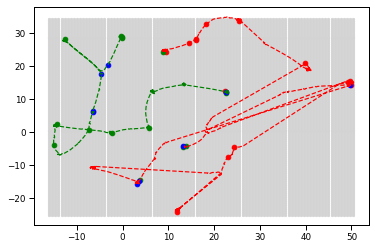

In [55]:
vertices = xy_grid.reshape(resolution**2, 2)

plt.scatter(vertices[:, 0], vertices[:, 1], c='lightgrey', marker='.')
plt.plot(forces_emb[:, 0], forces_emb[:, 1], 'r--')
plt.plot(bos_emb[:, 0], bos_emb[:, 1], 'g--')
plt.scatter(questions_embs[:15, 0], questions_embs[:15, 1], c='r', marker='o')
plt.scatter(questions_embs[15:30, 0], questions_embs[15:30, 1], c='g', marker='o')
plt.scatter(questions_embs[30:, 0], questions_embs[30:, 1], c='b', marker='o')

In [56]:
# save fit UMAP reducer and 2D embeddings
# np.save(opj(models_dir, 'UMAP_reducer'), reducer)
# np.save(opj(embeddings_dir, 'forces_lecture'), forces_emb)
# np.save(opj(embeddings_dir, 'bos_lecture'), bos_emb)
# np.save(opj(embeddings_dir, 'questions'), questions_embs)
# exp.load_reducer()
# exp.load_embeddings()

## Construct knowledge maps from memory traces for embedded lectures

In [57]:
lecture_embs = np.vstack((forces_emb, bos_emb))
maps_arr = np.empty((3, exp.n_participants, resolution, resolution), dtype=np.float64)

for qset in range(3):
    store_key = f'kmap_qset{qset}'
    for i, p in enumerate(tqdm(participants, desc=f'{qset+1}/3', leave=False)):
        forces_trace = p.get_trace(f'forces_qset{qset}')
        bos_trace = p.get_trace(f'bos_qset{qset}')
        traces = np.hstack((forces_trace, bos_trace))
        # interpolate traces to regular grid using radial basis function
        knowledge_map = RBF_interp(lecture_embs, traces, vertices, width=5).reshape(resolution, resolution)
        p.store_trace(knowledge_map, store_key)
        maps_arr[qset, i] = knowledge_map
        
    # store average in avg participant
    avg_participant.store_trace(maps_arr[qset].mean(axis=0), store_key)
    
exp.participants = participants
exp.avg_participant = avg_participant

In [58]:
# uniformly shift coordinates to line up with heatmap for plotting
embeddings_plotscaled = embeddings - embeddings.min(axis=0)
embeddings_plotscaled /= (embeddings_plotscaled.max(axis=0) / resolution)
forces_plotscaled, bos_plotscaled, questions_plotscaled = np.vsplit(embeddings_plotscaled, split_inds)
ff_qs_plotscaled = questions_plotscaled[:15]
bos_qs_plotscaled = questions_plotscaled[15:30]
gen_qs_plotscaled = questions_plotscaled[30:]

0.3 0.5
0.3 0.9
0.7 0.9


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


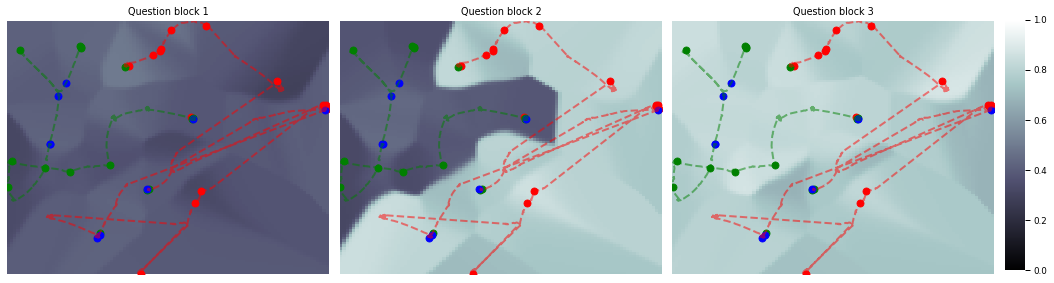

In [64]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(14, 4)
cbar_ax = fig.add_axes([1, 0.05, .02, .87])

for i in range(3):
    kmap = avg_participant.traces[f'kmap_qset{i}']
    low, high = kmap.min().round(1), kmap.max().round(1)
    print(low, high)
    cbar = True if i == 2 else False
    cax = cbar_ax if i == 2 else None
    sns.heatmap(kmap, vmin=0, vmax=1, cmap='bone', xticklabels=[], yticklabels=[], 
                cbar=cbar, ax=axes[i], cbar_ax=cax)
    axes[i].plot(forces_plotscaled[:, 0], forces_plotscaled[:, 1], 'r--', alpha=.5, linewidth=2)
    axes[i].plot(bos_plotscaled[:, 0], bos_plotscaled[:, 1], 'g--', alpha=.5, linewidth=2)
#     axes[i].scatter(questions_plotscaled[:, 0], questions_plotscaled[:, 1], c='b', marker='o', s=50)
    axes[i].scatter(ff_qs_plotscaled[:, 0], ff_qs_plotscaled[:, 1], c='r', marker='o', s=50)
    axes[i].scatter(bos_qs_plotscaled[:, 0], bos_qs_plotscaled[:, 1], c='g', marker='o', s=50)
    axes[i].scatter(gen_qs_plotscaled[:, 0], gen_qs_plotscaled[:, 1], c='b', marker='o', s=50)
    axes[i].set_title(f'Question block {i + 1}')
    axes[i].invert_yaxis()
plt.tight_layout()
plt.show()

-0.08700579480914272 0.5353173393308899
-0.07043627182941725 0.5355628037730813


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


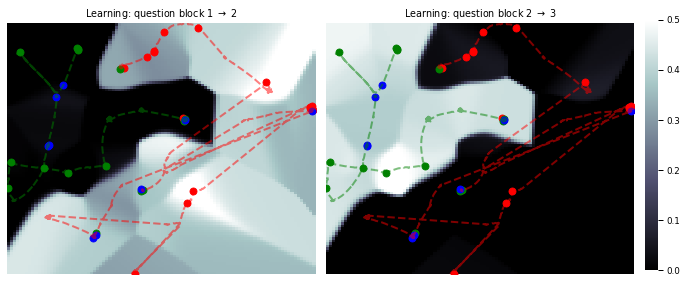

In [60]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(9, 4)
cbar_ax = fig.add_axes([1, 0.05, .02, .87])
for i in range(2):
    learning_map = avg_participant.traces[f'kmap_qset{i + 1}'] - avg_participant.traces[f'kmap_qset{i}']
    print(learning_map.min(), learning_map.max())
    cbar = True if i == 1 else False
    cax = cbar_ax if i == 1 else None
    sns.heatmap(learning_map, vmin=0, vmax=.5, cmap='bone', xticklabels=[], yticklabels=[],
               cbar=cbar, ax=axes[i], cbar_ax=cbar_ax)
    axes[i].plot(forces_plotscaled[:, 0], forces_plotscaled[:, 1], 'r--', alpha=.5, linewidth=2)
    axes[i].plot(bos_plotscaled[:, 0], bos_plotscaled[:, 1], 'g--', alpha=.5, linewidth=2)
#     axes[i].scatter(questions_plotscaled[:, 0], questions_plotscaled[:, 1], c='b', marker='o', s=50)
    axes[i].scatter(ff_qs_plotscaled[:, 0], ff_qs_plotscaled[:, 1], c='r', marker='o', s=50)
    axes[i].scatter(bos_qs_plotscaled[:, 0], bos_qs_plotscaled[:, 1], c='g', marker='o', s=50)
    axes[i].scatter(gen_qs_plotscaled[:, 0], gen_qs_plotscaled[:, 1], c='b', marker='o', s=50)
    axes[i].set_title(r'Learning: question block {} $\rightarrow$ {}'.format((i + 1), (i + 2)))
    axes[i].invert_yaxis()
plt.tight_layout()
plt.show()

## Recover topic vectors for some sample knowledge map coordinates

In [554]:
# # inverse-transform grid into original topic space
# np.random.seed(reducer.transform_seed)
# topic_space_vertices = reducer.inverse_transform(vertices).astype(np.float64)
# # undo log-transform & normalize
# topic_space_vertices = np.exp(topic_space_vertices)
# topic_space_vertices /= topic_space_vertices.sum(axis=1, keepdims=True)
# # reshape to grid
# topic_space_grid = topic_space_vertices.reshape(resolution, resolution, n_topics)

2


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


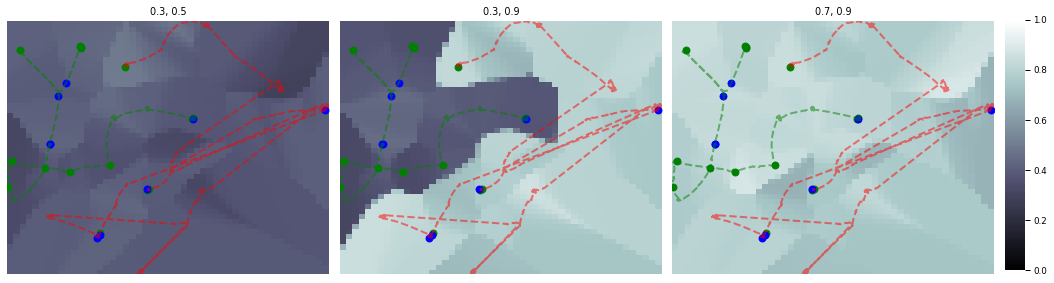

-0.09216194652384557 0.5456382565309301
-0.07050491557675798 0.5409986079892619


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


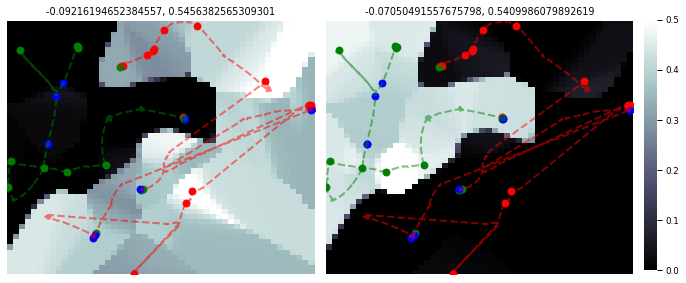

5


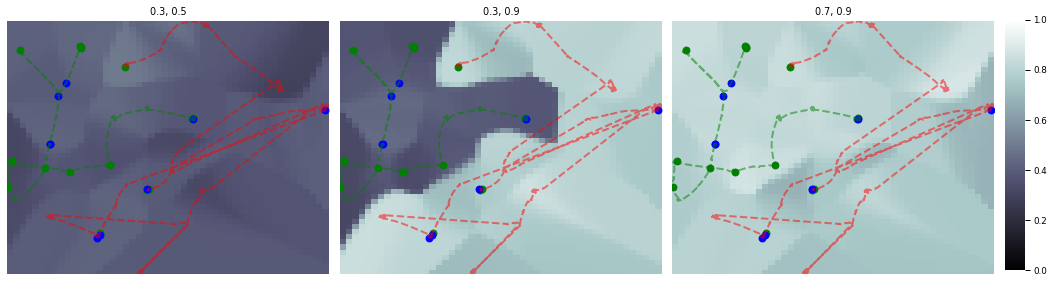

-0.08695179567954253 0.5347586710565424
-0.07034766237128176 0.5355628037730811


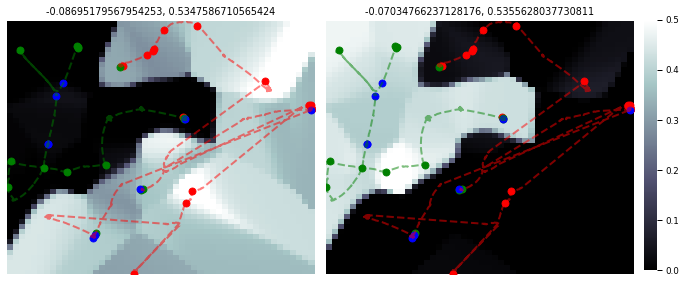

10


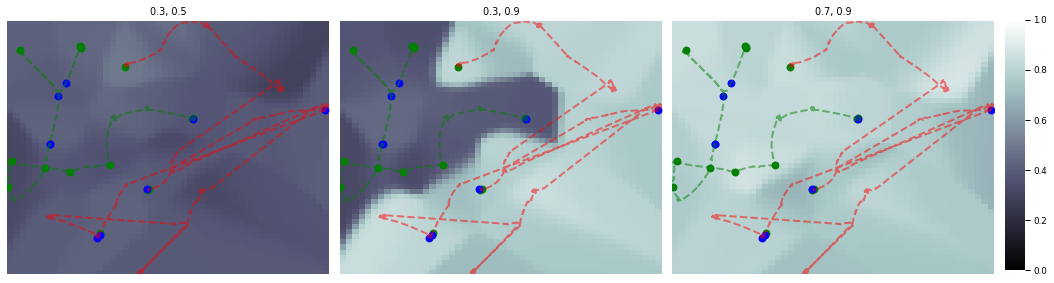

-0.08476758027560782 0.5209767593922277
-0.06973424081198387 0.5249090337783766


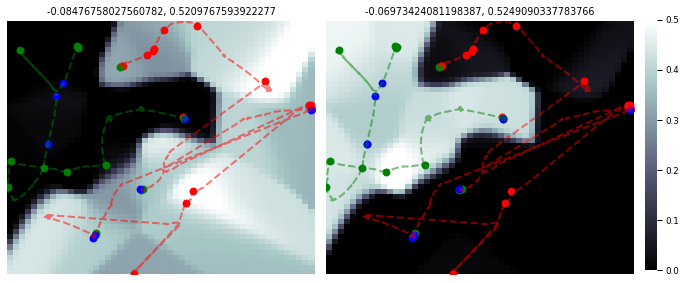

15


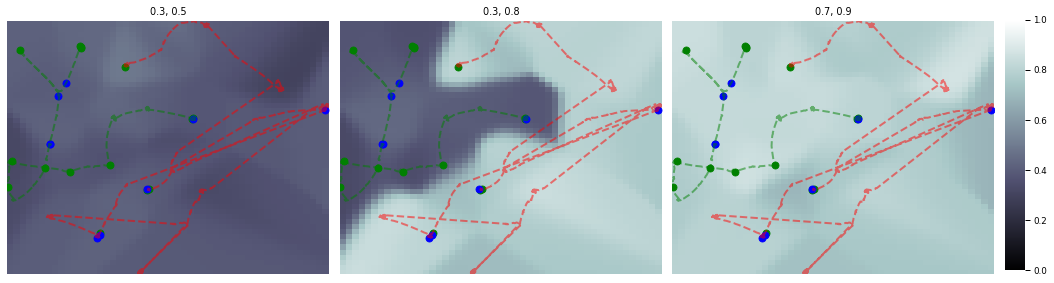

-0.08379352626295838 0.5164033917541809
-0.06851802014493147 0.5143464384742004


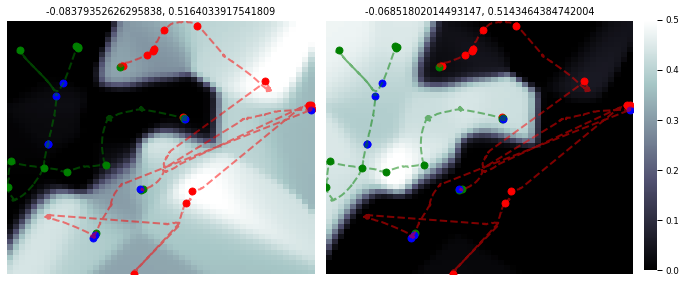

20


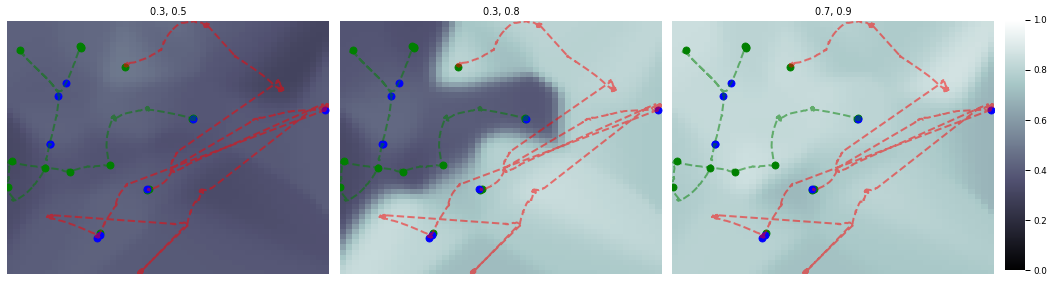

-0.08278036617412932 0.5120261333051415
-0.0677223436246539 0.5033801646323168


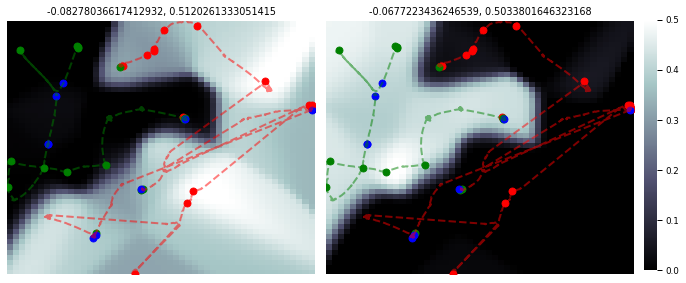

30


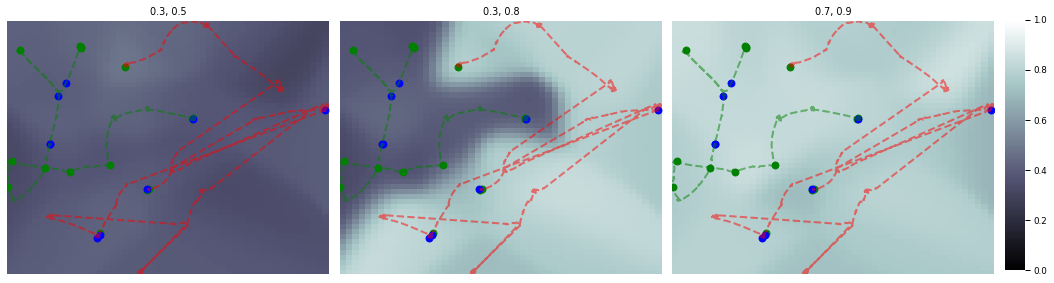

-0.07882600354167613 0.5029185960211956
-0.066742030018066 0.480378853321562


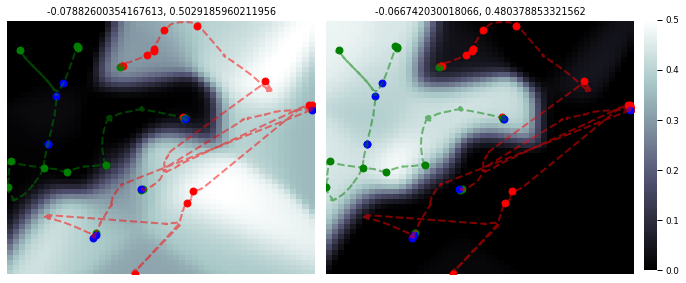

50


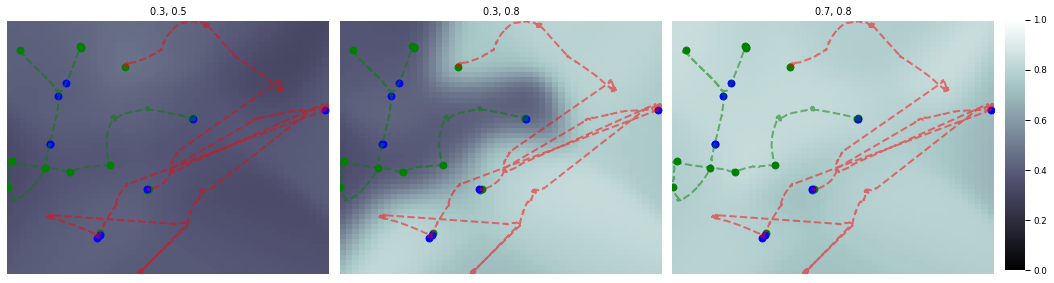

-0.06154452494453844 0.4930385266729616
-0.06341713725067077 0.47091473857424615


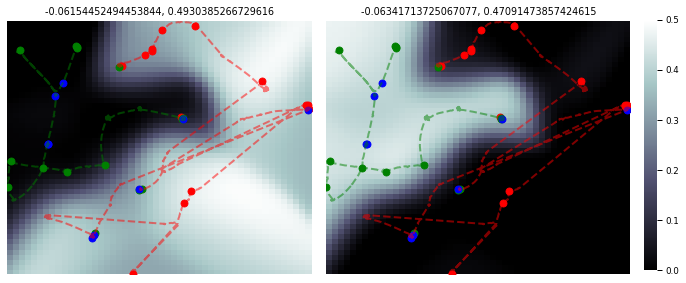

In [53]:
for width in (2, 5, 10, 15, 20, 30, 50):
    print(width)
    maps_arr = np.empty((3, exp.n_participants, resolution, resolution), dtype=np.float64)
    for qset in range(3):
        store_key = f'kmap_qset{qset}'
        for i, p in enumerate(tqdm(participants, desc=f'{qset+1}/3', leave=False)):
            forces_trace = p.get_trace(f'forces_qset{qset}')
            bos_trace = p.get_trace(f'bos_qset{qset}')
            traces = np.hstack((forces_trace, bos_trace))
            # interpolate traces to regular grid using radial basis function
            knowledge_map = RBF_interp(lecture_embs, traces, vertices, width=width).reshape(resolution, resolution)
            p.store_trace(knowledge_map, store_key)
            maps_arr[qset, i] = knowledge_map
        # store average in avg participant
        avg_participant.store_trace(maps_arr[qset].mean(axis=0), store_key)
    exp.participants = participants
    exp.avg_participant = avg_participant
    
    fig, axes = plt.subplots(1, 3)
    fig.set_size_inches(14, 4)
    cbar_ax = fig.add_axes([1, 0.05, .02, .87])
    for i in range(3):
        kmap = avg_participant.traces[f'kmap_qset{i}']
        low, high = kmap.min().round(1), kmap.max().round(1)
        cbar = True if i == 2 else False
        cax = cbar_ax if i == 2 else None
        sns.heatmap(kmap, vmin=0, vmax=1, cmap='bone', xticklabels=[], yticklabels=[], 
                    cbar=cbar, ax=axes[i], cbar_ax=cax)
        axes[i].plot(forces_plotscaled[:, 0], forces_plotscaled[:, 1], 'r--', alpha=.5, linewidth=2)
        axes[i].plot(bos_plotscaled[:, 0], bos_plotscaled[:, 1], 'g--', alpha=.5, linewidth=2)
        axes[i].scatter(bos_qs_plotscaled[:, 0], bos_qs_plotscaled[:, 1], c='g', marker='o', s=50)
        axes[i].scatter(gen_qs_plotscaled[:, 0], gen_qs_plotscaled[:, 1], c='b', marker='o', s=50)
        axes[i].set_title(f'{low}, {high}')
        axes[i].invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(9, 4)
    cbar_ax = fig.add_axes([1, 0.05, .02, .87])
    for i in range(2):
        learning_map = avg_participant.traces[f'kmap_qset{i + 1}'] - avg_participant.traces[f'kmap_qset{i}']
        print(learning_map.min(), learning_map.max())
        cbar = True if i == 1 else False
        cax = cbar_ax if i == 1 else None
        sns.heatmap(learning_map, vmin=0, vmax=.5, cmap='bone', xticklabels=[], yticklabels=[],
                   cbar=cbar, ax=axes[i], cbar_ax=cbar_ax)
        axes[i].plot(forces_plotscaled[:, 0], forces_plotscaled[:, 1], 'r--', alpha=.5, linewidth=2)
        axes[i].plot(bos_plotscaled[:, 0], bos_plotscaled[:, 1], 'g--', alpha=.5, linewidth=2)
    #     axes[i].scatter(questions_plotscaled[:, 0], questions_plotscaled[:, 1], c='b', marker='o', s=50)
        axes[i].scatter(ff_qs_plotscaled[:, 0], ff_qs_plotscaled[:, 1], c='r', marker='o', s=50)
        axes[i].scatter(bos_qs_plotscaled[:, 0], bos_qs_plotscaled[:, 1], c='g', marker='o', s=50)
        axes[i].scatter(gen_qs_plotscaled[:, 0], gen_qs_plotscaled[:, 1], c='b', marker='o', s=50)
        axes[i].set_title(f'{learning_map.min()}, {learning_map.max()}')
        axes[i].invert_yaxis()
    plt.tight_layout()
    plt.show()